In [15]:
import sqlite3
import lifelines
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import warnings
warnings.filterwarnings('ignore')

conn = sqlite3.connect("../data/sample_20210509.sqlite")

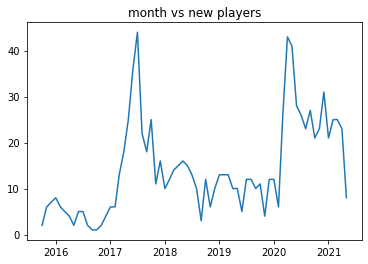

,month,n
0,2015-10-01,2
1,2015-11-01,6
2,2015-12-01,7
3,2016-01-01,8
4,2016-02-01,6
...,...,...
63,2021-01-01,21
64,2021-02-01,25
65,2021-03-01,25
66,2021-04-01,23


In [74]:
df = pd.read_sql_query("""
    SELECT 
        date(timestamp, "start of month") as month,
        count(distinct name) as n
    FROM levels
    WHERE level = 2
    group by 1
""", conn)
df["month"] = pd.to_datetime(df.month)
plt.plot(df.month, df.n)
plt.title("month vs new players")
plt.show()
df

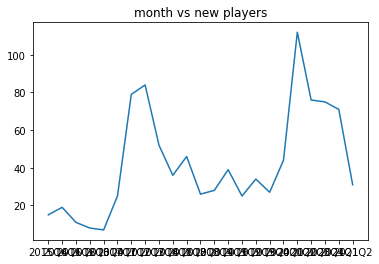

In [102]:
df["quarter"] = pd.to_datetime(df.month).dt.to_period("Q").apply(lambda x: str(x))
df_q = df.groupby("quarter").sum().reset_index()
plt.plot(df_q.quarter, df_q.n)
plt.title("month vs new players")
plt.show()

In [141]:
level = 70
df = pd.read_sql_query(f"""
    with recent as (
        select 
            name,
            max(level) as level,
            min(timestamp) as start_ts,
            max(timestamp) as end_ts,
            date(min(timestamp), "start of month") as starting_month
        from levels
        where level <= {level}
        group by 1
    )
    select
        name,
        starting_month as original_starting_month,
        date(starting_month, printf("-%i month", (strftime('%m', starting_month)-1) % 4)) as starting_month,
        iif(level < {level}, julianday("2021-05-09"), julianday(end_ts)) -julianday(start_ts) as duration,
        level = {level} as observed
    from recent
""", conn)
df

,name,original_starting_month,starting_month,duration,observed
0,0100,2019-03-01,2019-01-01,789.443472,0
1,0men,2019-12-01,2019-09-01,23.027905,1
2,12PM,2021-03-01,2021-01-01,51.246887,0
3,1stTimeMaple,2016-07-01,2016-05-01,1768.058241,0
4,20XX,2017-03-01,2017-01-01,13.892130,1
...,...,...,...,...,...
979,yhwach,2018-05-01,2018-05-01,1074.440903,0
980,zImBaby,2015-12-01,2015-09-01,1959.207627,0
981,zenq,2020-03-01,2020-01-01,406.435961,0
982,zzaapp,2021-04-01,2021-01-01,31.685313,0


Text(0.5, 1.0, 'count of new players per quarter')

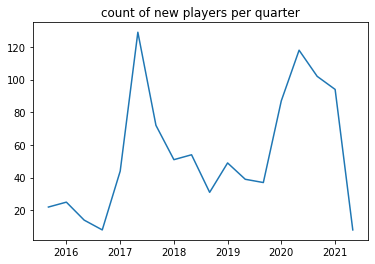

In [273]:
x = df.groupby("starting_month").count().name.reset_index()
plt.plot(pd.to_datetime(x.starting_month), x.name)
plt.title("count of new players per quarter")

In [224]:
import numpy as np

def get_surv(level, dates, end=90, quarter=False, legend=True):
    df = pd.read_sql_query(f"""
        with recent as (
            select 
                name,
                max(level) as level,
                min(timestamp) as start_ts,
                max(timestamp) as end_ts,
                date(min(timestamp), "start of month") as starting_month
            from levels
            where level <= {level}
            group by 1
        )
        select
            name,
            {
                "date(starting_month, printf('-%i month', (strftime('%m', starting_month)-1) % 4))" 
                if quarter else "starting_month"
            } as starting_month,
            iif(level < {level}, julianday("2021-05-09"), julianday(end_ts)) -julianday(start_ts) as duration,
            level = {level} as observed
        from recent
    """, conn)
    surv = []
    kmf = KaplanMeierFitter()
    ax = plt.subplot(111)
    dates = sorted(df.starting_month.unique()) if dates is None else dates
    for starting_month in dates:
        x = df[df.starting_month == starting_month]
        kmf.fit(x.duration, event_observed=x.observed, timeline=np.arange(0, 90, 1/24))
        est = 1-kmf.survival_function_.KM_estimate.iloc[-1]
        kmf.plot_survival_function(ax=ax, label=f"{starting_month} ({est:.2f} @{level})")
        surv.append(dict(
            starting_month=starting_month, 
            surv=est,
            p75=kmf.percentile(0.75),
            p90=kmf.percentile(0.90),
            p95=kmf.percentile(0.95),
            p99=kmf.percentile(0.99)
        ))

    plt.title("survival function of players at min. level")
    plt.ylabel("probablity not leveled")
    plt.xlabel("timescale (days)")
    if not legend:
        plt.gca().get_legend().remove()
    return pd.DataFrame(surv)

,starting_month,surv,p75,p90,p95,p99
0,2020-04-01,0.534884,14.416667,11.708333,9.833333,8.958333
1,2017-07-01,0.386364,29.791667,19.208333,11.000000,6.833333
2,2018-10-01,0.416667,78.625000,17.541667,7.083333,7.083333


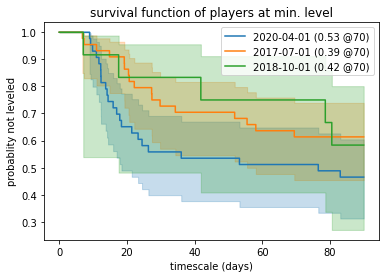

In [225]:
get_surv(70, ["2020-04-01", "2017-07-01", "2018-10-01"])

,starting_month,surv,p75,p90,p95,p99
0,2017-07-01,0.613636,2.250000,1.416667,0.458333,0.416667
1,2020-04-01,0.790698,1.333333,1.083333,0.458333,0.208333


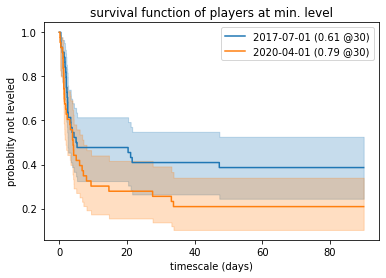

In [271]:
get_surv(30, ["2017-07-01", "2020-04-01"])

,starting_month,surv,p75,p90,p95,p99
0,2017-07-01,0.386364,29.791667,19.208333,11.000000,6.833333
1,2020-04-01,0.534884,14.416667,11.708333,9.833333,8.958333


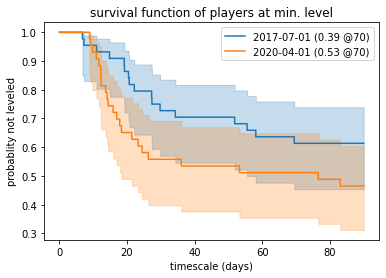

In [272]:
get_surv(70, ["2017-07-01", "2020-04-01"])

,starting_month,surv,p75,p90,p95,p99
0,2020-04-01,0.348837,44.833333,27.50,22.208333,16.541667
1,2017-07-01,0.288889,65.250000,28.75,23.833333,17.791667


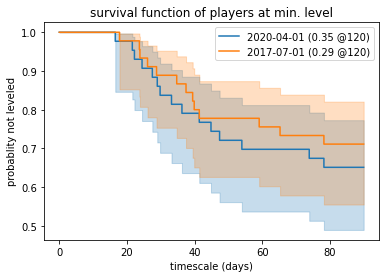

In [228]:
get_surv(120, ["2020-04-01", "2017-07-01"])

,starting_month,surv,p75,p90,p95,p99
0,2020-04-01,0.534884,14.416667,11.708333,9.833333,8.958333
1,2020-05-01,0.439024,19.125000,11.166667,5.875000,5.291667
2,2020-06-01,0.357143,40.750000,8.333333,7.500000,7.125000
3,2020-07-01,0.269231,67.208333,6.458333,6.375000,6.333333


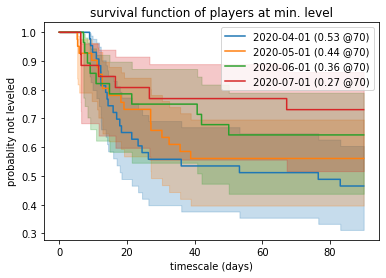

In [229]:
get_surv(70, ["2020-04-01", "2020-05-01", "2020-06-01", "2020-07-01"])

- 2019-12-21 Christmas patch
- 2020-02-16 Lunar New Year + Valentines patch
- 2020-05-22 Anniversary patch
- 2020-08-30 Summer patch
- 2020-10-31 Halloween patch
- 2020-12-20 Christmas patch
- 2021-02-19 Valentines patch

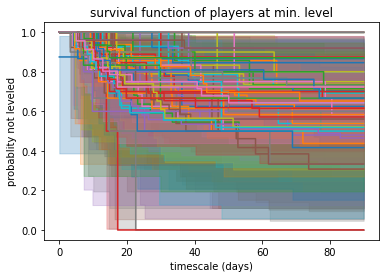

In [230]:
res70 = get_surv(70, None, legend=False)

In [263]:
def make_plots(level, quarter=True, start_date=None):
    df = get_surv(level, None, quarter=quarter, legend=False)
    df = df[df.starting_month < "2021-01-01"]
    if start_date:
        df = df[df.starting_month >= start_date]
    plt.show()
    
    x = "month" if not quarter else "quarter"
    
    plt.plot(pd.to_datetime(df.starting_month), df.surv)
    plt.title(f"probability survived after 90 days for quarterly cohorts (level {level})")
    plt.xlabel(x)
    plt.xticks(rotation=45)
    plt.ylabel("probability survived (90 days)")
    plt.show()
    
    plt.plot(pd.to_datetime(df.starting_month), df.p90)
    plt.title(f"time for 10% of population to reach (level {level})")
    plt.xlabel(x)
    plt.xticks(rotation=45)
    plt.ylabel("days")
    plt.show()
    
    plt.plot(pd.to_datetime(df.starting_month), df.p75)
    plt.title(f"time for 25% of population to reach (level {level})")
    plt.xlabel(x)
    plt.xticks(rotation=45)
    plt.ylabel("days")
    plt.show()

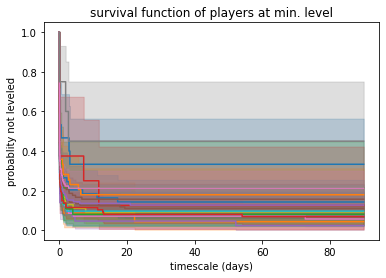

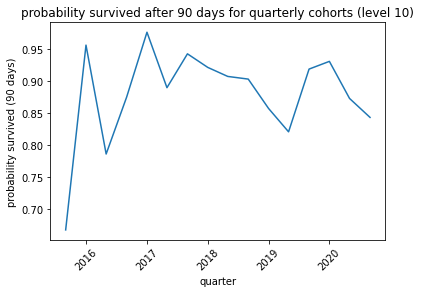

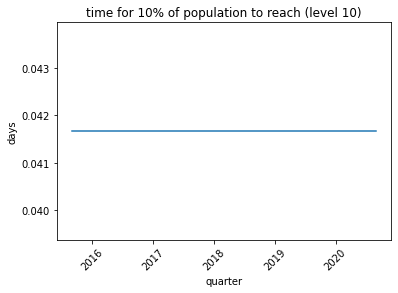

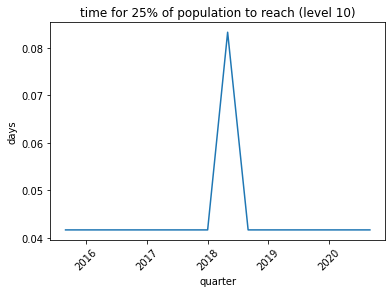

In [264]:
make_plots(10)

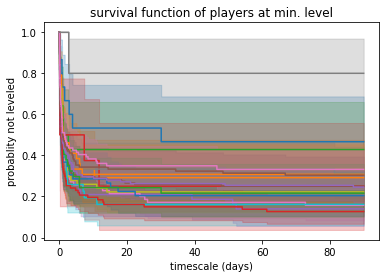

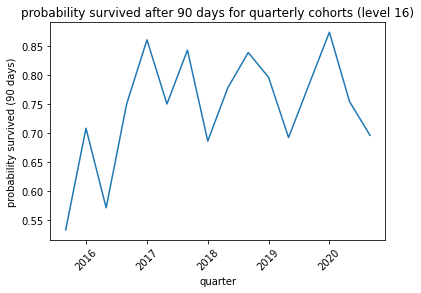

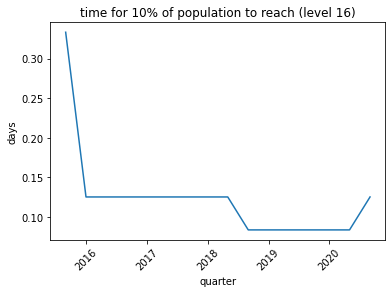

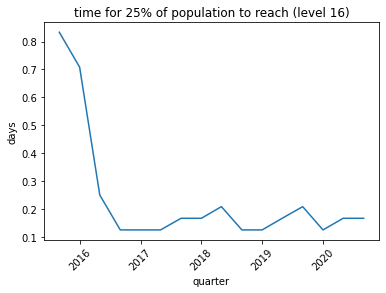

In [265]:
make_plots(16)

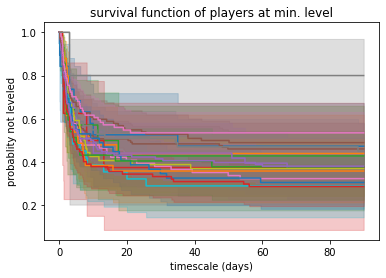

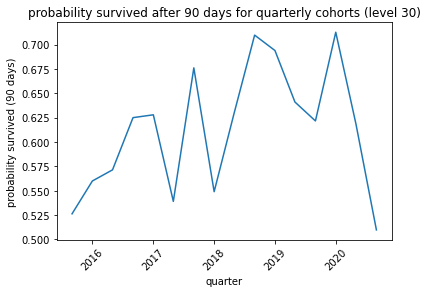

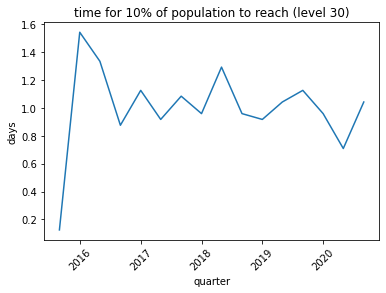

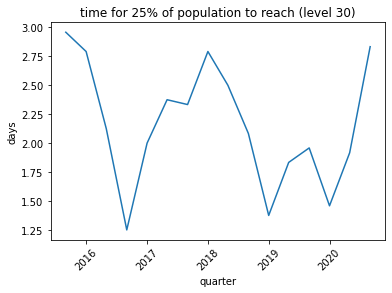

In [266]:
make_plots(30)

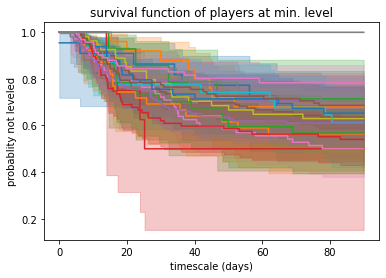

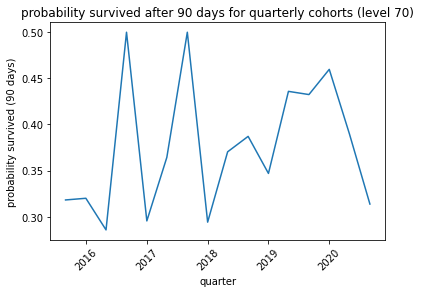

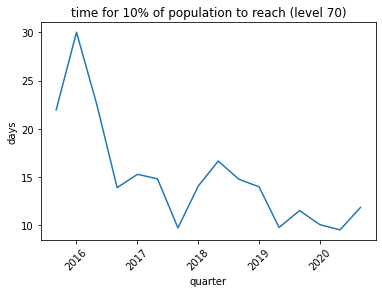

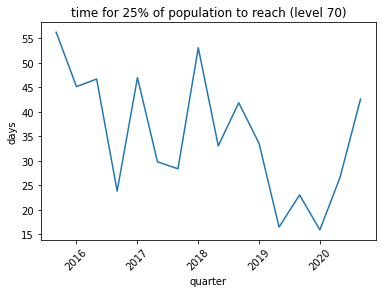

In [267]:
make_plots(70)

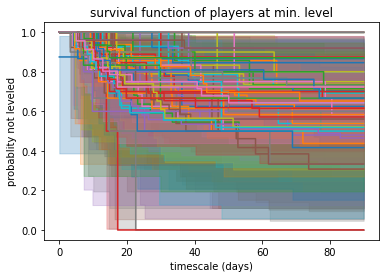

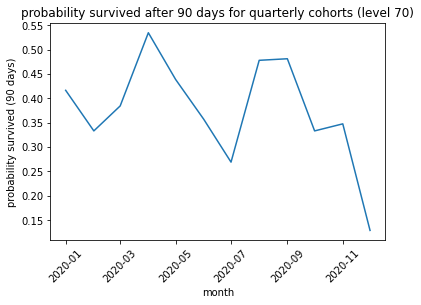

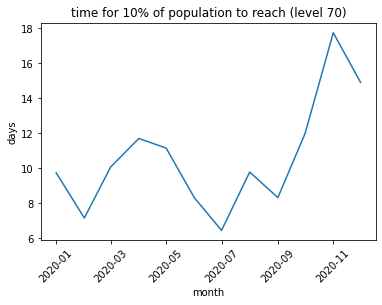

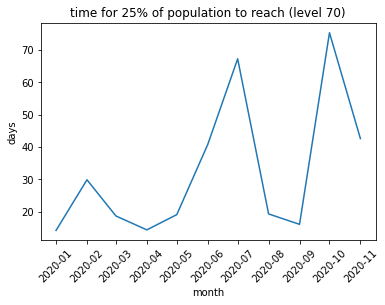

In [268]:
make_plots(70, quarter=False, start_date="2020-01-01")